In [53]:
import pandas as pd
import requests
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': 'BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4'}
    request = requests.post('https://graphql.bitquery.io/', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        print(request.reason)
        raise Exception('Query failed and return code is {}.{}'.format(request.status_code, query))

query_date = '"2021-12-16", "{}"'.format(str(datetime.date.today()))

# Convert this to JSON

VOLT_ACCOUNTS = {
    # CSP
    "SOL-P": "6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK",
    "SOL-P-high": "JAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf",
    "BTC-P": "GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f",
    "SOL-P (tsUSDC)": "AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8",
    "ETH-P": "EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax",
    "LUNA-P": "5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj",
    "MNGO-P": "CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6",
#     "SOL-P-Step": ,
#     "SOL-P-Parrot": ,
#     "SOL-P-UXD": ,
    
    "SOL-C": "Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G",
    "SOL-C-high": "DNa849drqW19uBV5X9ohpJ5brRGzq856gk3HDRqveFrA",
    "BTC-C": "DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du",
    "mSOL-C": "6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH",
    "ETH-C": "FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp",
    "FTT-C": "7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K",
    "SRM-C": "2P427N5sYcEXvZAZwqNzjXEHsBMESQoLyjNquTSmGPMb",
    "MNGO-C": "B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ",
    "scnSOL-C": "A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A",
    "SBR-C": "BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h",
    "LUNA-C": "5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X",
    "RAY-C": "A6XsYxGj9wpqUZG81XwgQJ2zJ3efCbuWSQfnkHqUSmdM",
    "STEP-C": "FiEHDTKT6X7VFwGaUmsm1XXYr8vvkoSR5EqcY4znpefq",
    "AVAX-C": "HLfkEc6E2HEcABaWm3QZSfDvswzXjh1onF9xEzUAtWNS",
    
#     "scnSOL-T": "E4T6eD28PGHeydcUGgMVTtw1vrX5q23fyN7TSFFM4Eox"
}

ACCOUNT_STRING = str(list(VOLT_ACCOUNTS.values())).replace("\'", "\"")

FEES_ADDRESS = '3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ'

MASTER_ADDRESS = 'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE'

query = """
    query{
    solana(network: solana) {
    transfers(
      date: {between: ["""+ query_date +"""]}
      transferType: {is: transfer}
      any: [{senderAddress: {in: """ + ACCOUNT_STRING + """}}]
    ) {
      amount
      currency {
        symbol
        address
      }
      block {
        timestamp {
          iso8601
        }
      }
      transaction {
        signer
        signature
        innerInstructionsCount
      }
      receiver {
        address
      }
      sender {
        address
      }
    }
  }
}
"""

result = run_query(query)
# convert GraphQL json to pandas dataframe
df = pd.json_normalize(result['data']['solana']['transfers'])
df = df.rename(columns={"block.timestamp.iso8601": "date", "currency.symbol": "symbol", 
                        "transaction.signer":"signer", "currency.address":"cash",
                        "receiver.address":"receiver", "sender.address":"sender", "transaction.signature": "tx_id"})
# Does json_normalize flatten a json file for you??

df["tx_id"] = df["tx_id"].apply(lambda x: "https://solscan.io/tx/{}".format(x))
# if transaction signer & receiver is diff, drop row
# df = df.query("signer == receiver").reset_index(drop=True)
df = df.query("signer == receiver").reset_index(drop=True)

def find_key(value, d):
    for k, v in d.items():
        if value == v:
            return k

df['asset'] = df.sender.apply(lambda x: find_key(x, VOLT_ACCOUNTS))

df['symbol'] = df.apply(lambda x: "tsUSDC" if x.cash == "Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip" else x.symbol, axis=1)

df["FeeType"] = df["transaction.innerInstructionsCount"].apply(lambda x: "Withdrawal Fee" if x==1 else "Performance Fee")

In [54]:
yy = df.loc[df.asset.str.split("-").apply(lambda x: x[0]) == df.symbol]

In [55]:
yy.sort_values("date").loc[yy.signer!="DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE"]

,amount,symbol,cash,date,signer,tx_id,transaction.innerInstructionsCount,receiver,sender,asset,FeeType
8459,0.001998,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2021-12-16T17:44:06Z,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,https://solscan.io/tx/3MQUdjZezedLm9mMBYdX4HiHGtaMeTGqoSwQt7C8Ps8BRx1ikBV3FrYHxC9eBmBFeFs2irJmymYndf8ChPa5SSAn,3,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Performance Fee
11132,4.950000,SOL,So11111111111111111111111111111111111111112,2021-12-17T19:07:42Z,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,https://solscan.io/tx/287P2jcJpFvhPDhsw7cFSJDctUKv8iW3rvs9u4XyKePTUdWekqgfUXS6C4X4u2C7QoV2pZhf2FtUKRE2thdTwTUo,4,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Performance Fee
10222,4.950000,SOL,-,2021-12-17T19:07:42Z,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,https://solscan.io/tx/287P2jcJpFvhPDhsw7cFSJDctUKv8iW3rvs9u4XyKePTUdWekqgfUXS6C4X4u2C7QoV2pZhf2FtUKRE2thdTwTUo,4,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Performance Fee
10223,1.584000,SOL,-,2021-12-17T19:29:04Z,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,https://solscan.io/tx/5Qz4XJidp6e6BdDawk3BFeTAHeiEhEfRF7uBYfngAGF1kCPJxYUXBU3MkfEZEfmL5LMkRKyDVYT16YWW3XJw6Tqv,3,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Performance Fee
11133,1.584000,SOL,So11111111111111111111111111111111111111112,2021-12-17T19:29:04Z,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,https://solscan.io/tx/5Qz4XJidp6e6BdDawk3BFeTAHeiEhEfRF7uBYfngAGF1kCPJxYUXBU3MkfEZEfmL5LMkRKyDVYT16YWW3XJw6Tqv,3,7jZVLYBFHfLXEUHxVCxDHDxxxtREALKd2e7QrYu87YSs,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Performance Fee
...,...,...,...,...,...,...,...,...,...,...,...
10221,3217.542010,SBR,Saber2gLauYim4Mvftnrasomsv6NvAuncvMEZwcLpD1,2022-03-24T15:57:02Z,CNwvrE2jMKg7fB5B4DQXXRb6DxpZ2vdRerXgT9km12rm,https://solscan.io/tx/5Y2Ckgdijuqhbo16gmq1eUfrNgHfWY9FNvbivESrgGcSafsvkg3AE4Vk1uKdqQVszpSSuvhC7n9sbNyVFPdcBrnx,1,CNwvrE2jMKg7fB5B4DQXXRb6DxpZ2vdRerXgT9km12rm,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,SBR-C,Withdrawal Fee
9904,1718.404099,MNGO,MangoCzJ36AjZyKwVj3VnYU4GTonjfVEnJmvvWaxLac,2022-03-24T19:34:03Z,7QfCRDvZcSaDCDB5JntkLz23UeE9YkKc7MGyjBMEb1VY,https://solscan.io/tx/415nS7kTLzxtaBS4HP99xFBpDTygoRzqzsV2i6p2URk2HvLtMPhs3nbqz7JCwe2FgEiTsMZhkDw4Zm41vqLqDLU5,2,7QfCRDvZcSaDCDB5JntkLz23UeE9YkKc7MGyjBMEb1VY,B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ,MNGO-C,Performance Fee
13024,0.150000,SOL,So11111111111111111111111111111111111111112,2022-03-24T19:47:13Z,6SvTZfYs53eUpvYWnywdqzgud5x5atzubPhns82Aa3R7,https://solscan.io/tx/4DJtv5fPo4rtpHTAZ9Ka6oyZEpqiQ5HjDzhQdLFeaNuhDqGUoc316X9aWUnmBeM2vrpNRb8EDRthKoUahYhuPdj1,1,6SvTZfYs53eUpvYWnywdqzgud5x5atzubPhns82Aa3R7,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Withdrawal Fee
9813,23.213176,LUNA,F6v4wfAdJB8D8p77bMXZgYt8TDKsYxLYxH5AFhUkYx9W,2022-03-24T20:27:27Z,7cqa7tPYNgWw8eRNDcBosEQxYJ4uKXfDMHFmBhxH3uQN,https://solscan.io/tx/3aw1GhPXCNpfmG2qEGgrfGhVro8Zi5cn8QG4MLWhDPiqtV89d6Qyhsvy1UJ2FLfwkjRLPQvm7dTW9C1pxZJWxLSm,1,7cqa7tPYNgWw8eRNDcBosEQxYJ4uKXfDMHFmBhxH3uQN,5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X,LUNA-C,Withdrawal Fee


In [56]:
yy["day"] = pd.to_datetime(yy.date).dt.dayofweek

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_62990/215074038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yy["day"] = pd.to_datetime(yy.date).dt.dayofweek


In [57]:
yy.groupby("day").symbol.count()

day
0     353
1     366
2     281
3     251
4    3250
5     758
6     382
Name: symbol, dtype: int64

In [61]:
query

'\n    query{\n    solana(network: solana) {\n    transfers(\n      date: {between: ["2021-12-16", "2022-03-24"]}\n      transferType: {is: transfer}\n      any: [{senderAddress: {in: ["6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK", "JAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf", "GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f", "AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8", "EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax", "5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj", "CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6", "Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G", "DNa849drqW19uBV5X9ohpJ5brRGzq856gk3HDRqveFrA", "DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du", "6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH", "FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp", "7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K", "2P427N5sYcEXvZAZwqNzjXEHsBMESQoLyjNquTSmGPMb", "B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ", "A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A", "BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h", "

In [58]:
result

{'data': {'solana': {'transfers': [{'amount': 75000.0,
     'currency': {'symbol': '',
      'address': '23RQ3r2JFCgHG7pNFAQmrNBAt3TfRd9onCJyvZ9QEZ4q'},
     'block': {'timestamp': {'iso8601': '2022-02-11T09:05:36Z'}},
     'transaction': {'signer': 'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE',
      'signature': '31EPFAsFQAoHCwzPQ93BA9vFT9HBhjz34WRB7yYt8yK3rWNdW2jJn9cpNaKCoAJWrzA3phYaE4yv6uMKQdFxP9bJ',
      'innerInstructionsCount': 13},
     'receiver': {'address': '9Z8LRng3N2mNSkbDAXkaCHfknMbRV7ndSFseMTEvqmKj'},
     'sender': {'address': 'Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G'}},
    {'amount': 139080.0,
     'currency': {'symbol': '',
      'address': '23RQ3r2JFCgHG7pNFAQmrNBAt3TfRd9onCJyvZ9QEZ4q'},
     'block': {'timestamp': {'iso8601': '2022-02-11T09:07:01Z'}},
     'transaction': {'signer': 'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE',
      'signature': '3Tu7dNzWMUWaECGeeJrDwvhmeXRsWf3SEaSJ2LyWkCqHgGtKd1w5gxMw8Xx3VAns8WhJnVn9NSB5gC1nz3eyyL5E',
      'innerInstruct

In [59]:
yy.loc[yy.day==4]

,amount,symbol,cash,date,signer,tx_id,transaction.innerInstructionsCount,receiver,sender,asset,FeeType,day
8461,0.040240,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2021-12-31T12:53:54Z,9DWREMQtcKKcZRzqBi4kWKp61TW9MhASCVE9biCX7tvD,https://solscan.io/tx/3wbUV8dM6EJnKziBCuiqDbeMseydB15ZDHsE1E7yEpgeRipydcjjYmZaSuZp3vEUqzGQyMqBebAGJeu8Dg7Bnb5m,1,9DWREMQtcKKcZRzqBi4kWKp61TW9MhASCVE9biCX7tvD,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Withdrawal Fee,4
8462,0.008550,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2021-12-31T14:13:37Z,DFhvkpq3vVKAPtpTZ4QHFrZugc9Ksg72xFVmJ54TLcbZ,https://solscan.io/tx/5TpoTNbg2YWSzBu3MEs8KkZgewVSukus7QVVkjmrKx8YjN6k6qJ2NFZReB26sCkbF7dEQzRiknEcGdASVyDgTHbF,1,DFhvkpq3vVKAPtpTZ4QHFrZugc9Ksg72xFVmJ54TLcbZ,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Withdrawal Fee,4
8463,0.017807,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2021-12-31T23:26:23Z,GNmr8LvrKqddAXVkvtVv69RkroqjrFQdnfAT5wG9GZUk,https://solscan.io/tx/2c5tAfMH6JJjjDyQrFxbxU612uFfQQmGnBgEaXVVCnovSywNqMjgQH3kDMUnuqrZCLH7557thyAEpw97kwgS8yhP,1,GNmr8LvrKqddAXVkvtVv69RkroqjrFQdnfAT5wG9GZUk,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Withdrawal Fee,4
8465,0.020108,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2022-01-07T09:02:48Z,4S35XSu9JGSoy47LBBqcgnE3ZB4XdfmvQhTgwssRkZkR,https://solscan.io/tx/4Yr9EnLQsq9snpDq9ZwwgHYKWzdvczsZKM7CiusGEGM9iBSVG894aMSVN7ziFacv4TjE8cW4sGw6zopRK5KdZagG,1,4S35XSu9JGSoy47LBBqcgnE3ZB4XdfmvQhTgwssRkZkR,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Withdrawal Fee,4
8466,0.201488,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2022-01-07T09:06:29Z,7qhHMUy9QGKx2oE2jyUXM28D61xs4LCDyfq8gPC85dCS,https://solscan.io/tx/3JpGaMP7AK4mqSpL1T4R3rvkLbJj6cqTqvCtRtkc49JzqyMp31Q8xszxFZ4DJkJSqi1XE4TTZqywgpETqwt5oRuL,1,7qhHMUy9QGKx2oE2jyUXM28D61xs4LCDyfq8gPC85dCS,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,BTC-C,Withdrawal Fee,4
...,...,...,...,...,...,...,...,...,...,...,...,...
15423,18.118515,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-18T07:47:42Z,JCi24aXNERWqJ7ZeuiZCpkgYKg5eNdnveACdWDxhA1pP,https://solscan.io/tx/4YtUHZu7EeAWBg4HgEiACydJgwBVZ2e8PHRg67zuFjnME66gdaowChF1VkRX7sB1BwLzuJTyMouz1hAnF2WdLYK7,1,JCi24aXNERWqJ7ZeuiZCpkgYKg5eNdnveACdWDxhA1pP,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,scnSOL-C,Withdrawal Fee,4
15424,6.867554,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-18T13:23:48Z,E2LNEimm9X7gCKiTgSbUwjg8s8wx5Yz71UQRKNeBtTTC,https://solscan.io/tx/49ncbv4yssoWUTK1b5WM9hjDduZbTv2hv4K4oLFT3SEiYQjbh8xCzbkW2MDECAJpHJEz58BjwUWJ18gULjZNJUAt,1,E2LNEimm9X7gCKiTgSbUwjg8s8wx5Yz71UQRKNeBtTTC,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,scnSOL-C,Withdrawal Fee,4
15425,3.087989,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-18T15:39:11Z,ChiEbNvAvhQcQd2axacLA9TY2XHHsQUBc2iHvc1rjA23,https://solscan.io/tx/4THvzn9js9CFt2W5iYNNn7MUcWGJxGvhvsHhNwg8sLU9yYthHnFAt3bhNDcfWDJpWLZWzznYMnz95Cuuk6Cfgkyv,1,ChiEbNvAvhQcQd2axacLA9TY2XHHsQUBc2iHvc1rjA23,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,scnSOL-C,Withdrawal Fee,4
15426,3.132774,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-18T16:03:28Z,6o2ASdEoRGDZaaHRupBmocL7wKWNpyMXkFKePGsSs79p,https://solscan.io/tx/4gfWrvPSZixxcwRBE8AwoNoXnFwSrRezTNKcD48HZCE4VwfNZYM8smxYwqwgoqvbRZu6Lx4P5YaMPSzvxQ2ZDXvC,1,6o2ASdEoRGDZaaHRupBmocL7wKWNpyMXkFKePGsSs79p,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,scnSOL-C,Withdrawal Fee,4


In [60]:
yy.sort_values("amount")[::-1][250:]

,amount,symbol,cash,date,signer,tx_id,transaction.innerInstructionsCount,receiver,sender,asset,FeeType,day
15190,2.148921e+03,mSOL,mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,2022-03-18T02:30:49Z,BireEhAhnhgwrXSzTfdGXRVB2hwYh5pDevsSLBaJrDLo,https://solscan.io/tx/47EEGEqTb678Ex2aS22vE3c3ALv6BLaQhBE8wr93orx726M1BV2nEMpwHHRR592jVdUhafWgP3fKcuVy9oDGgL2L,1,BireEhAhnhgwrXSzTfdGXRVB2hwYh5pDevsSLBaJrDLo,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,mSOL-C,Withdrawal Fee,4
9051,2.124904e+03,FTT,AGFEad2et2ZJif9jaGpdMixQqvW5i81aBdvKe7PHNfz3,2022-01-21T14:46:17Z,4XLecP6KyZRq9qYJGo8YcpsQYke9cgKnGjx2Y1oPpjBT,https://solscan.io/tx/3vBeEagf31QFjU5QWjykHFwLmuRKymWsaSEaXJvxhNUoTJjGREQQrNy2FkHyGEu8QxffuceVvkjHvXV62Hneue4L,1,4XLecP6KyZRq9qYJGo8YcpsQYke9cgKnGjx2Y1oPpjBT,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,FTT-C,Withdrawal Fee,4
10077,2.111478e+03,SBR,Saber2gLauYim4Mvftnrasomsv6NvAuncvMEZwcLpD1,2022-01-30T11:16:26Z,GHKAMqHV3kbya3ccFD3jnCyMdpiAV9maLuxsmqe4RcBL,https://solscan.io/tx/2rzACp8X5SsEWMRyheLnsBk6h2pTUm8XXUSddnfHtu8r5bF5dmeFMxgQDrmeDFLHJzEWogNPRBTJAZVMjKcNYGZX,1,GHKAMqHV3kbya3ccFD3jnCyMdpiAV9maLuxsmqe4RcBL,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,SBR-C,Withdrawal Fee,6
14779,2.107504e+03,mSOL,mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,2022-01-28T16:39:13Z,BireEhAhnhgwrXSzTfdGXRVB2hwYh5pDevsSLBaJrDLo,https://solscan.io/tx/9aJMPL92HDXBmEnmCH6S6mz3pV5k3xy2Ys1WgYewDVysBYD5zXNbxGiNALDdthQkAGcXrvrUcZCzfaKuinB9HCA,1,BireEhAhnhgwrXSzTfdGXRVB2hwYh5pDevsSLBaJrDLo,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,mSOL-C,Withdrawal Fee,4
10103,2.074786e+03,SBR,Saber2gLauYim4Mvftnrasomsv6NvAuncvMEZwcLpD1,2022-02-05T11:34:49Z,GaSVxveDeaFFe2qzkEE48nNKhp9CK7v951EfhYibdavb,https://solscan.io/tx/3Xfb2Bt3b9z2fQHuDTABh3vggvYYusA9MyHno51X1EoQad1ESJMm36HMTE1DRihWtFzmpckBhutGYCw8FfhC2KPt,1,GaSVxveDeaFFe2qzkEE48nNKhp9CK7v951EfhYibdavb,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,SBR-C,Withdrawal Fee,5
...,...,...,...,...,...,...,...,...,...,...,...,...
12445,3.080000e-07,SOL,So11111111111111111111111111111111111111112,2022-02-24T22:53:08Z,F4bQN5RgTr5o2emKYHLTdYGYb7J4ydKtJChPHFX9sS9q,https://solscan.io/tx/BZM48HtsS2Q4sEfAKGnc6wS9Vk65QnTttZa5uiUmugGm6XD3NfwRAU9xVi89aekWFzhpzRicRuod94sG6AvEJgN,1,F4bQN5RgTr5o2emKYHLTdYGYb7J4ydKtJChPHFX9sS9q,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Withdrawal Fee,3
12326,3.000000e-09,SOL,So11111111111111111111111111111111111111112,2022-02-18T11:12:38Z,GzFELEUV1J9mwB6UznG58oWR3L9ipQxdgf3hWYqFvZ6Q,https://solscan.io/tx/33w71hoHWKgfdCsPWKQPX3vuxasAxWT7P5vdL3WhDN6iE8WRYxJmZNaVxZni9xxkGSGMWMxPwefX8fvpTxHngGnN,1,GzFELEUV1J9mwB6UznG58oWR3L9ipQxdgf3hWYqFvZ6Q,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,SOL-C,Withdrawal Fee,4
15069,1.000000e-09,mSOL,mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,2022-02-24T22:51:06Z,3V1HmecLr55cdDLEXzhN8tfz7qCq7UdD2KwjB4VT4duQ,https://solscan.io/tx/4LAVRNfPkvqP5xfNpyTU49DUmef7BzSPwqmdxbFQRD5EygwNmnHb7FTDo4NKvQw64jdLH8C7md4Dc8qCUAFeAVpz,1,3V1HmecLr55cdDLEXzhN8tfz7qCq7UdD2KwjB4VT4duQ,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,mSOL-C,Withdrawal Fee,3
8486,0.000000e+00,BTC,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E,2022-01-12T00:13:15Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/2qJLaau8jHfESDZ1r2uZGnnqVwYRL1Kq4T5hstSvuhKAWyhE1ub4UPp4dSLY2uP44QGE4hvXf9zB6xTwzFigNJUk,1,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,BTC-P,Withdrawal Fee,2


<AxesSubplot:xlabel='date'>

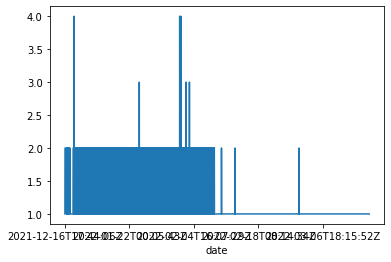

In [12]:
df.loc[df.FeeType=="Withdrawal Fee"]

,amount,symbol,cash,date,signer,tx_id,transaction.innerInstructionsCount,receiver,asset,FeeType
11,79.320857,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-02-18T06:53:25Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/2Czi9NRr5Jo35tyffYcW2btmAWBiEpeqbsSiawXBGD24dDz7h7ybHpksgqiwX6rYYpRCoUF3ZSdT7vDZzesL64Ch,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Withdrawal Fee
13,177.568196,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-02-25T03:09:41Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/4bQTJrtD8fv42nyw8KCggE7w95jXihBhXNMxYT81Qx99qYj1hAY61qnYtcP7KErwviirYK1mseRG9JN31tiP2Rtm,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Withdrawal Fee
15,15.149637,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-03-04T02:43:34Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/53TQ2XzfEsYudXahHDGQVnwrQNg9hNsuCSupeddVuvZtBAqiEydjUdYjh2oPTw7e7bERaLt3a6FUH39wni6mE1ZT,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Withdrawal Fee
17,19.436179,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-03-11T02:50:32Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/57cX4JYMnKorTsQj6mqWayst3SU3k2EmBnBSrCN34BH6Y8GgkVvYHFeEvB9vbiHLSscurCW1mDZgJRMgRfGpPkfa,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Withdrawal Fee
19,3056.092388,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-03-18T02:41:58Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/5JDK51iQy7kjUNtNAodrKQEuqSSUCVgKTRmCswg4PF9c2QmgQegf6CKo4VjsCkMHW54Q1hfKhHyDiCCAFRQxfS4G,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Withdrawal Fee
...,...,...,...,...,...,...,...,...,...,...
347,0.668252,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-02-18T08:18:03Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/4D3KvYELXKhHWiPx7froKfuoP6qnU5AHXPkxanfdokX4yyhaGuZ9s4j7JnascSc1kp18MALSeiYw6KM1GXw2yhuG,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,scnSOL-C,Withdrawal Fee
350,0.527556,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-02-25T02:34:29Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/56vybLcq2SPcr8oRmvTKA4XG3L23oRNxa97hA7QU9hNRR6NWPrKfgwJg1sg8aJJHSHhJSAY1eeJrQAXfmhQKceSp,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,scnSOL-C,Withdrawal Fee
352,0.155903,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-04T02:35:04Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/4faQvHiNLqkXW3u7AbTEfgkppMw7QX5SvjxRmSwJpbi7iEFZgBP4ot3GgrWGoaCKKZvdHcstKMmVMEmh67nmThx5,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,scnSOL-C,Withdrawal Fee
354,0.059191,scnSOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,2022-03-11T02:38:27Z,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,https://solscan.io/tx/2au46PfswbWyZwaM5b7VRrxwG8RBEMdPC2DGU9gcv1z684U89dbfiDiiNd3SjzYSpYTrbmddox1VRRrhFcaXwzQT,1,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,scnSOL-C,Withdrawal Fee


In [13]:
df.groupby(["asset", "FeeType", "symbol"]).amount.sum()

asset           FeeType          symbol
BTC-C           Performance Fee  BTC           1.222333
                Withdrawal Fee   BTC           0.256253
BTC-P           Performance Fee  USDC       6008.832171
                Withdrawal Fee   USDC        166.403252
ETH-C           Performance Fee  ETH           3.955708
                Withdrawal Fee   ETH           1.397977
ETH-P           Performance Fee  USDC        795.276182
                Withdrawal Fee   USDC        247.435746
FTT-C           Performance Fee  FTT         493.787061
                Withdrawal Fee   FTT          28.859512
LUNA-C          Performance Fee  LUNA        465.510641
                Withdrawal Fee   LUNA         92.565639
LUNA-P          Performance Fee  UST        2951.350868
                Withdrawal Fee   UST         423.862711
MNGO-C          Performance Fee  MNGO      22098.953302
                Withdrawal Fee   MNGO       3499.265779
MNGO-P          Performance Fee  USDC       1550.948694
        